In [201]:
# 从sklearn 调入所需要的包
# from sklearn import datasets

import os
import json
import gc
# os.system('pip install numba')
from numba import jit
#tqdm
# os.system('pip install tqdm')
from tqdm import tqdm_notebook
from tqdm import tqdm

#Integrated model
# os.system('pip install lightgbm')
import lightgbm as lgb
# os.system('pip install catboost==0.15.2')
import catboost as cbt
# os.system('pip install xgboost')
# import xgboost as xgb

#base import 
import numpy as np
import pandas as pd

# about sklearn
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler as std
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import f1_score
#about time
import time
import datetime 
from datetime import datetime, timedelta

#Garbage collection
import gc
# scipy
from scipy.signal import hilbert
from scipy.signal import hann
from scipy.signal import convolve
from scipy import stats
import scipy.spatial.distance as dist
#other
from collections import Counter 
from statistics import mode 
    #warning
import warnings
warnings.filterwarnings("ignore")
import json 
import math
from itertools import product
import ast
from sklearn.model_selection import train_test_split #数据分隔出训练集和验证集
import lightgbm as lgb
import numpy as np 
import pandas as pd
#导入精度和召回
from sklearn.metrics import precision_score, recall_score
import lightgbm as lgb
pd.set_option('display.max_columns',None)

In [202]:
# 减少内存消耗
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

## 获取数据

In [203]:
path = "./"
train = pd.read_csv(path + "input/train.csv", encoding="utf-8")
test = pd.read_csv(path + "input/test.csv", encoding="utf-8")

In [204]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [205]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [206]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [207]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

In [208]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [209]:
test.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1459.000000,1459.000000,1232.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1444.000000,1458.000000,1458.000000,1458.000000,1458.000000,1459.000000,1459.000000,1459.000000,1459.000000,1457.000000,1457.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.00000,1381.000000,1458.000000,1458.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000
mean,2190.000000,57.378341,68.580357,9819.161069,6.078821,5.553804,1971.357779,1983.662783,100.709141,439.203704,52.619342,554.294925,1046.117970,1156.534613,325.967786,3.543523,1486.045922,0.434454,0.065202,1.570939,0.377656,2.854010,1.042495,6.385195,0.58122,1977.721217,1.766118,472.768861,93.174777,48.313914,24.243317,1.794380,17.064428,1.744345,58.167923,6.104181,2007.769705
std,421.321334,42.746880,22.376841,4955.517327,1.436812,1.113740,30.390071,21.130467,177.625900,455.268042,176.753926,437.260486,442.898624,398.165820,420.610226,44.043251,485.566099,0.530648,0.252468,0.555190,0.503017,0.829788,0.208472,1.508895,0.64742,26.431175,0.775945,217.048611,127.744882,68.883364,67.227765,20.207842,56.609763,30.491646,630.806978,2.722432,1.301740
min,1461.000000,20.000000,21.000000,1470.000000,1.000000,1.000000,1879.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,407.000000,0.000000,0.000000,407.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.00000,1895.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,1825.500000,20.000000,58.000000,7391.000000,5.000000,5.000000,1953.000000,1963.000000,0.000000,0.000000,0.000000,219.250000,784.000000,873.500000,0.000000,0.000000,1117.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.00000,1959.000000,1.000000,318.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,2190.000000,50.000000,67.000000,9399.000000,6.000000,5.000000,1973.000000,1992.000000,0.000000,350.500000,0.000000,460.000000,988.000000,1079.000000,0.000000,0.000000,1432.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,0.00000,1979.000000,2.000000,480.000000,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,2554.500000,70.000000,80.000000,11517.500000,7.000000,6.000000,2001.000000,2004.000000,164.000000,753.500000,0.000000,797.750000,1305.000000,1382.500000,676.000000,0.000000,1721.000000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.00000,2002.000000,2.000000,576.000000,168.000000,72.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,2919.000000,190.000000,200.000000,56600.000000,10.000000,9.000000,2010.000000,2010.000000,1290.000000,4010.000000,1526.000000,2140.000000,5095.000000,5095.000000,1862.000000,1064.000000,5095.000000,3.000000,2.000000,4.000000,2.000000,6.000000,2.000000,15.000000,4.00000,2207.000000,5.000000,1488.000000,1424.000000,742.000000,1012.000000,360.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


In [210]:
# 相关性
train.corr()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,1.000000,0.011156,-0.010601,-0.033226,-0.028365,0.012609,-0.012713,-0.021998,-0.050298,-0.005024,-0.005968,-0.007940,-0.015415,0.010496,0.005590,-0.044230,0.008273,0.002289,-0.020155,0.005587,0.006784,0.037719,0.002951,0.027239,-0.019772,0.000072,0.016570,0.017634,-0.029643,-0.000477,0.002889,-0.046635,0.001330,0.057044,-0.006242,0.021172,0.000712,-0.021917
MSSubClass,0.011156,1.000000,-0.386347,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.022936,-0.069836,-0.065649,-0.140759,-0.238518,-0.251758,0.307886,0.046474,0.074853,0.003491,-0.002333,0.131608,0.177354,-0.023438,0.281721,0.040380,-0.045569,0.085072,-0.040110,-0.098672,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407,-0.084284
LotFrontage,-0.010601,-0.386347,1.000000,0.426095,0.251646,-0.059213,0.123349,0.088866,0.193458,0.233633,0.049900,0.132644,0.392075,0.457181,0.080177,0.038469,0.402797,0.100949,-0.007234,0.198769,0.053532,0.263170,-0.006069,0.352096,0.266639,0.070250,0.285691,0.344997,0.088521,0.151972,0.010700,0.070029,0.041383,0.206167,0.003368,0.011200,0.007450,0.351799
LotArea,-0.033226,-0.139781,0.426095,1.000000,0.105806,-0.005636,0.014228,0.013788,0.104160,0.214103,0.111170,-0.002618,0.260833,0.299475,0.050986,0.004779,0.263116,0.158155,0.048046,0.126031,0.014259,0.119690,-0.017784,0.190015,0.271364,-0.024947,0.154871,0.180403,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261,0.263843
OverallQual,-0.028365,0.032628,0.251646,0.105806,1.000000,-0.091932,0.572323,0.550684,0.411876,0.239666,-0.059119,0.308159,0.537808,0.476224,0.295493,-0.030429,0.593007,0.111098,-0.040150,0.550600,0.273458,0.101676,-0.183882,0.427452,0.396765,0.547766,0.600671,0.562022,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347,0.790982
OverallCond,0.012609,-0.059316,-0.059213,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.128101,-0.046231,0.040229,-0.136841,-0.171098,-0.144203,0.028942,0.025494,-0.079686,-0.054942,0.117821,-0.194149,-0.060769,0.012980,-0.087001,-0.057583,-0.023820,-0.324297,-0.185758,-0.151521,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950,-0.077856
YearBuilt,-0.012713,0.027850,0.123349,0.014228,0.572323,-0.375983,1.000000,0.592855,0.315707,0.249503,-0.049107,0.149040,0.391452,0.281986,0.010308,-0.183784,0.199010,0.187599,-0.038162,0.468271,0.242656,-0.070651,-0.174800,0.095589,0.147716,0.825667,0.537850,0.478954,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618,0.522897
YearRemodAdd,-0.021998,0.040581,0.088866,0.013788,0.550684,0.073741,0.592855,1.000000,0.179618,0.128451,-0.067759,0.181133,0.291066,0.240379,0.140024,-0.062419,0.287389,0.119470,-0.012337,0.439046,0.183331,-0.040581,-0.149598,0.191740,0.112581,0.642277,0.420622,0.371600,0.205726,0.226298,-0.193919,0.045286,-0.038740,0.005829,-0.010286,0.021490,0.035743,0.507101
MasVnrArea,-0.050298,0.022936,0.193458,0.104160,0.411876,-0.128101,0.315707,0.179618,1.000000,0.264736,-0.072319,0.114442,0.363936,0.344501,0.174561,-0.069071,0.390857,0.085310,0.026673,0.276833,0.201444,0.102821,-0.037610,0.280682,0.249070,0.252691,0.364204,0.373066,0.159718,0.125703,-0.110204,0.018796,0.061466,0.011723,-0.029815,-0.005965,-0.008201,0.477493
BsmtFinSF1,-0.005024,-0.069836,0.233633,0.214103,0.239666,-0.046231,0.249503,0.128451,0.264736,1.000000,-0.050117,-0.495251,0.522396,0.445863,-0.137079,-0.064503,0.208171,0.649212,0.067418,0.058543,0.004262,-0.107355,-0.081007,0.044316,0.260011,0.153484,0.224054,0.296970,0.204306,0.111761,-0.102303,0.026451

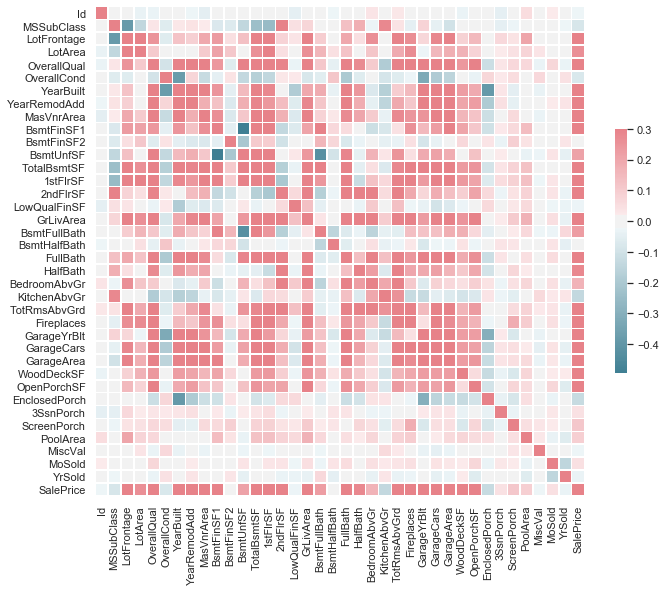

In [211]:
#查看特征直接的相关性
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style="white")
# 计算训练集的相关性
corr = train.corr()
# 设置 matplotlib f的尺寸
f, ax = plt.subplots(figsize=(11, 9))
# 生成自定义的散色图
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# 为热力图设置长宽比
sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [212]:
# 训练集和测试集
print("训练集的形状:{}".format(train.shape), "测试集的形状:{}".format(test.shape))

训练集的形状:(1460, 81) 测试集的形状:(1459, 80)


In [213]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [214]:
# 特征
features = [i for i in train.columns if i not in ["Id", "SalePrice"]]
# 类别特征
cat_col = [i for i in train.select_dtypes(object).columns if i not in ["Id", "SalePrice"]]
cat_col

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SaleCondition']

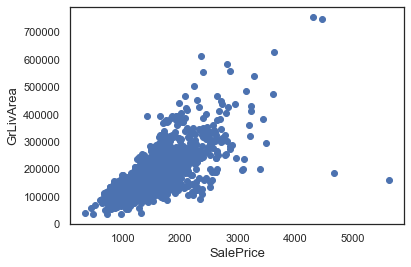

In [215]:
fig, ax = plt.subplots()
ax.scatter(x=train["GrLivArea"], y=train["SalePrice"])
plt.xlabel("SalePrice", fontsize=13)
plt.ylabel("GrLivArea", fontsize=13)
plt.show()

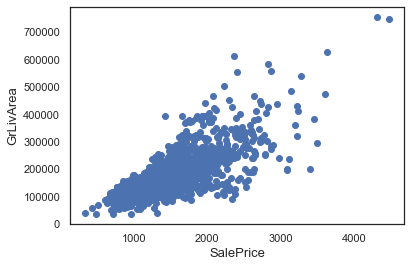

In [216]:
# 地面居住面积平方英尺
train = train.drop(train[(train["GrLivArea"] > 4000) & (train["SalePrice"] < 300000)].index)

fig, ax = plt.subplots()
ax.scatter(x=train["GrLivArea"], y=train["SalePrice"])
plt.xlabel("SalePrice", fontsize=13)
plt.ylabel("GrLivArea", fontsize=13)
plt.show()

### 相关性

In [217]:
# import seaborn as sns
# from matplotlib import pyplot as plt
# cor_matrix = train[numeric_features+['happiness']].corr().round(2)
# # Plotting heatmap 
# fig = plt.figure(figsize=(18,18));
# sns.heatmap(cor_matrix, annot=True, center=0, cmap = sns.diverging_palette(250, 10, as_cmap=True), ax=plt.subplot(111));
# plt.show()

In [218]:
# import seaborn as sns
# from matplotlib import pyplot as plt
# cor_matrix = train[categorical_features+['target']].corr().round(2)
# # Plotting heatmap 
# fig = plt.figure(figsize=(18,18));
# sns.heatmap(cor_matrix, annot=True, center=0, cmap = sns.diverging_palette(250, 10, as_cmap=True), ax=plt.subplot(111));
# plt.show()

In [219]:
# import seaborn as sns
# from matplotlib import pyplot as plt
# cor_matrix = train[binary_features+['target']].corr().round(2)
# # Plotting heatmap 
# fig = plt.figure(figsize=(18,18));
# sns.heatmap(cor_matrix, annot=True, center=0, cmap = sns.diverging_palette(250, 10, as_cmap=True), ax=plt.subplot(111));
# plt.show()

### 缺失值

In [220]:
train.isnull().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

In [221]:
train.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1458 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1458 non-null   int64  
 1   MSSubClass     1458 non-null   int64  
 2   MSZoning       1458 non-null   object 
 3   LotFrontage    1199 non-null   float64
 4   LotArea        1458 non-null   int64  
 5   Street         1458 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1458 non-null   object 
 8   LandContour    1458 non-null   object 
 9   Utilities      1458 non-null   object 
 10  LotConfig      1458 non-null   object 
 11  LandSlope      1458 non-null   object 
 12  Neighborhood   1458 non-null   object 
 13  Condition1     1458 non-null   object 
 14  Condition2     1458 non-null   object 
 15  BldgType       1458 non-null   object 
 16  HouseStyle     1458 non-null   object 
 17  OverallQual    1458 non-null   int64  
 18  OverallC

In [222]:
test["SalePrice"] = -1
data = train.append(test).reset_index(drop=True)

In [223]:
all_data_na = (data.isnull().sum() / len(data)) * 100
all_data_na = all_data_na.drop(all_train_data_na[all_train_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({"Missing Ratio": all_data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.691464
MiscFeature,96.400411
Alley,93.212204
Fence,80.425094
FireplaceQu,48.680151
LotFrontage,16.660953
GarageFinish,5.450806
GarageYrBlt,5.450806
GarageQual,5.450806
GarageCond,5.450806


Text(0.5, 1.0, 'Percent misssing data by feature')

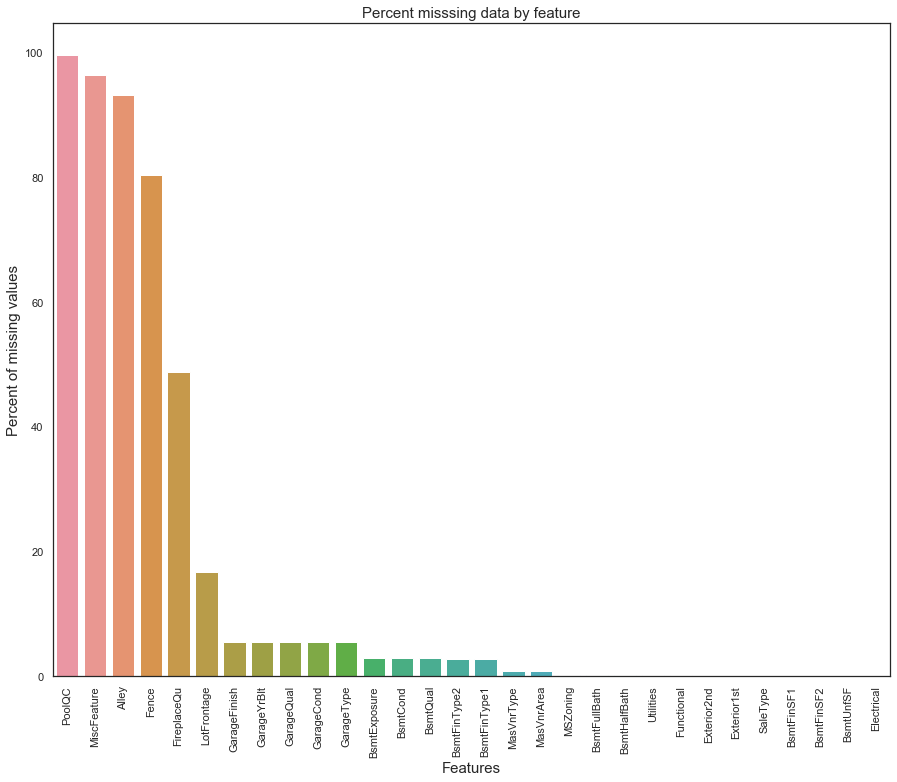

In [224]:
f, ax = plt.subplots(figsize=(15,12))
plt.xticks(rotation="90")
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel("Features", fontsize=15)
plt.ylabel("Percent of missing values", fontsize=15)
plt.title("Percent misssing data by feature", fontsize=15)

### 缺失值填充

In [225]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [226]:
# PoolQC：数据描述说NA表示“无池”。考虑到巨大的缺失价值比率（+ 99％），并且大多数房屋通常根本没有游泳池
data["PoolQC"] = data["PoolQC"].fillna("None")
# MiscFeature : data description says NA means "no misc feature"杂项功能：数据描述称不适用表示“无杂项功能”
data["MiscFeature"] = data["MiscFeature"].fillna("None")
# Alley：数据描述说NA意味着“没有胡同进入”
data["Alley"] = data["Alley"].fillna("None")
# Fence : data description says NA means "no fence" 围栏：数据描述说NA表示“没有围栏”
data["Fence"] = data["Fence"].fillna("None")
# FireplaceQu：数据描述说NA表示“没有壁炉”
data["FireplaceQu"] = data["FireplaceQu"].fillna("None")
# LotFrontage：由于连接到房屋属性的每条街道的面积很可能与附近的其他房屋具有相似的面积，因此我们可以通过附近的LotFrontage中位数来填充缺失值。
data["LotFrontage"] = data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

# 类别填充None
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    data[col] = data[col].fillna('None')
# 数值填充0
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    data[col] = data[col].fillna(0)
# 数值填充0
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    data[col] = data[col].fillna(0)
# 类别填充None
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    data[col] = data[col].fillna('None')
data["MasVnrType"] = data["MasVnrType"].fillna("None")
data["MasVnrArea"] = data["MasVnrArea"].fillna(0)
data["MSZoning"] = data["MSZoning"].fillna(data["MSZoning"].mode()[0])  # mode选取最常出现的值


### 删除多余特征

In [227]:
data.Utilities.value_counts()

AllPub    2914
NoSeWa       1
Name: Utilities, dtype: int64

In [228]:
# Utilities： 对于此分类功能，除一个“ NoSeWa”和两个NA外，所有记录均为“ AllPub”。由于带有“ NoSewa”的房屋在训练集中，因此此功能将不利于预测建模。然后，我们可以安全地将其删除。
data = data.drop(["Utilities"], axis=1)

### 增加特征

In [229]:
# 所有特征
features = [i for i in data.columns if i not in['Id','SalePrice']]
# 类别 特征
cat_col = [i for i in data.select_dtypes(object).columns if i not in ['Id','SalePrice']]
for i in tqdm_notebook(cat_col):
    lbl = LabelEncoder()
#     data["count_" + i] = data.groupby([i])[i].transform("count") # 增加count特征
    data[i] = lbl.fit_transform(data[i].astype(str))

In [230]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,3,65.0,8450,1,1,3,3,4,0,5,2,2,0,5,7,5,2003,2003,1,0,12,13,1,196.0,2,4,2,2,4,3,2,706.0,6,0.0,150.0,856.0,1,0,1,4,856,854,0,1710,1.0,0.0,2,1,3,1,2,8,6,0,3,1,2003.0,2,2.0,548.0,5,5,2,0,61,0,0,0,0,3,4,1,0,2,2008,8,4,208500
1,2,20,3,80.0,9600,1,1,3,3,2,0,24,1,2,0,2,6,8,1976,1976,1,0,8,8,2,0.0,3,4,1,2,4,1,0,978.0,6,0.0,284.0,1262.0,1,0,1,4,1262,0,0,1262,0.0,1.0,2,0,3,1,3,6,6,1,5,1,1976.0,2,2.0,460.0,5,5,2,298,0,0,0,0,0,3,4,1,0,5,2007,8,4,181500
2,3,60,3,68.0,11250,1,1,0,3,4,0,5,2,2,0,5,7,5,2001,2002,1,0,12,13,1,162.0,2,4,2,2,4,2,2,486.0,6,0.0,434.0,920.0,1,0,1,4,920,866,0,1786,1.0,0.0,2,1,3,1,2,6,6,1,5,1,2001.0,2,2.0,608.0,5,5,2,0,42,0,0,0,0,3,4,1,0,9,2008,8,4,223500
3,4,70,3,60.0,9550,1,1,0,3,0,0,6,2,2,0,5,7,5,1915,1970,1,0,13,15,2,0.0,3,4,0,4,1,3,0,216.0,6,0.0,540.0,756.0,1,2,1,4,961,756,0,1717,1.0,0.0,1,0,3,1,2,7,6,1,2,5,1998.0,3,3.0,642.0,5,5,2,0,35,272,0,0,0,3,4,1,0,2,2006,8,0,140000
4,5,60,3,84.0,14260,1,1,0,3,2,0,15,2,2,0,5,8,5,2000,2000,1,0,12,13,1,350.0,2,4,2,2,4,0,2,655.0,6,0.0,490.0,1145.0,1,0,1,4,1145,1053,0,2198,1.0,0.0,2,1,4,1,2,9,6,1,5,1,2000.0,2,3.0,836.0,5,5,2,192,84,0,0,0,0,3,4,1,0,12,2008,8,4,250000


In [231]:
data.SalePrice.value_counts()

-1         1459
 140000      20
 135000      17
 155000      14
 145000      14
           ... 
 109008       1
 232600       1
 145900       1
 72500        1
 206900       1
Name: SalePrice, Length: 663, dtype: int64

In [232]:
# ind_features = [c for c in features if 'ind' in c]
# count=0
# for c in ind_features:
#     if count==0:
#         data['new_ind'] = data[c].astype(str)+'_'
#         count+=1
#     else:
#         data['new_ind'] += data[c].astype(str)+'_'


# cat_count_features = []
# for c in categorical_features+['new_ind']:
#     d = data[c].value_counts().to_dict()
#     data['%s_count'%c] = data[c].apply(lambda x:d.get(x,0))
#     cat_count_features.append('%s_count'%c)
# del data['new_ind']

In [233]:
#one-hot操作
# for column in categorical_features:
#     temp = pd.get_dummies(pd.Series(data[column]))
#     data = pd.concat([data, temp], axis = 1)
#     data = data.drop([column], axis=1)

In [234]:
data.shape

(2917, 80)

In [235]:
feats = features

In [236]:
cat_list = cat_col

## 训练预测

### 分类架子：lightgbm,xgboost,catboost

In [237]:
# os.system('pip install lightgbm')
import lightgbm as lgb
# os.system('pip install catboost==0.15.2')
import catboost as cbt
# os.system('pip install xgboost')
from xgboost import XGBClassifier
xgb_model  = XGBClassifier(learning_rate=0.1,
                      n_estimators=1000,         # 树的个数--1000棵树建立xgboost
                       max_depth=6,               # 树的深度
                       min_child_weight = 1,      # 叶子节点最小权重
                      gamma=0.,                  # 惩罚项中叶子结点个数前的参数
                      subsample=0.8,             # 随机选择80%样本建立决策树
                       colsample_btree=0.8,       # 随机选择80%特征建立决策树
                       objective='binary:logistic', # 指定损失函数
                      scale_pos_weight=1,        # 解决样本个数不平衡的问题
                     random_state=27            # 随机数
                      )
lgb_model = lgb.LGBMClassifier(
        boosting_type="gbdt", num_leaves=15, reg_alpha=0, reg_lambda=0.,
    max_depth=-1, n_estimators=1500, objective='binary',metric= 'auc',
    subsample=0.95, colsample_bytree=0.95, subsample_freq=1,
    learning_rate=0.05, random_state=2017
    )
cbt_model = cbt.CatBoostClassifier(iterations=5000,learning_rate=0.1,max_depth=7,
                                           l2_leaf_reg=1,verbose=100,early_stopping_rounds=500,
                                            task_type='GPU',eval_metric='F1',cat_features=cat_list)

### 回归架子：lightgbm,xgboost,catboost

In [238]:
import xgboost as xgb
import catboost as cbt
import lightgbm as lgb
xgb_model = xgb.XGBRegressor(max_depth=8, learning_rate=0.1, n_estimators=160, silent=False)#, objective='reg:gamma'
lgb_model = lgb.LGBMRegressor(
    boosting_type="gbdt", num_leaves=31, reg_alpha=10, reg_lambda=5,
    max_depth=7, n_estimators=500,
    subsample=0.7, colsample_bytree=0.4, subsample_freq=2, min_child_samples=10,
    learning_rate=0.05, random_state=2019,
)

cbt_model = cbt.CatBoostRegressor(iterations=10,depth=5,learning_rate=0.1,loss_function='RMSE')

### 训练架子

In [239]:
def get_predict_w(model, data, label='label', feature=[], cate_feature=[], random_state=2018, n_splits=5,
                  model_type='lgb'):
    if 'sample_weight' not in data.keys():
        data['sample_weight'] = 1
    model.random_state = random_state
    predict_label = 'predict_' + label
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    data[predict_label] = 0
    test_index = (data[label].isnull()) | (data[label] == -1)
    train_data = data[~test_index].reset_index(drop=True)
    test_data = data[test_index]

    for train_idx, val_idx in kfold.split(train_data):
        model.random_state = model.random_state + 1
        train_x = train_data.loc[train_idx][feature]
        train_y = train_data.loc[train_idx][label]
        test_x = train_data.loc[val_idx][feature]
        test_y = train_data.loc[val_idx][label]
        if model_type == 'lgb':
            try:
                model.fit(train_x, train_y, eval_set=[(test_x, test_y)], early_stopping_rounds=100,
                          eval_metric='mae',
                          categorical_feature=cate_feature,
                          sample_weight=train_data.loc[train_idx]['sample_weight'],
                          verbose=100
                          )
            except:
                model.fit(train_x, train_y, eval_set=[(test_x, test_y)], early_stopping_rounds=100,
                          eval_metric='mae',
                          # categorical_feature=cate_feature,
                          sample_weight=train_data.loc[train_idx]['sample_weight'],
                          verbose=100)
        elif model_type == 'ctb':
            model.fit(train_x, train_y, eval_set=[(test_x, test_y)], early_stopping_rounds=100,
#                       eval_metric='mae',
#                       cate_features=cate_feature,
                      sample_weight=train_data.loc[train_idx]['sample_weight'],
                      verbose=100)
        elif model_type == 'xgb':
            model.fit(train_x, train_y, eval_set=[(test_x, test_y)], verbose=True, eval_metric='mae',
                      sample_weight=train_data.loc[train_idx]['sample_weight'], early_stopping_rounds=50)
        train_data.loc[val_idx, predict_label] = model.predict(test_x)
        if len(test_data) != 0:
            test_data[predict_label] = test_data[predict_label] + model.predict(test_data[feature])
    test_data[predict_label] = test_data[predict_label] / n_splits
    print(test_data[predict_label].head())
    return pd.concat([train_data, test_data], sort=True, ignore_index=True),test_data[predict_label]

In [240]:
# lgb
data_pre,test_pre = get_predict_w(lgb_model,data,label='SalePrice',feature=feats,cate_feature=[], random_state=2018, n_splits=5,
                  model_type='lgb')
pd.DataFrame({'Id':test['Id'],'SalePrice':test_pre.values}).to_csv('baselinelgb2.csv',index=False)

[100]	valid_0's l1: 14864.4	valid_0's l2: 5.46871e+08
[200]	valid_0's l1: 14345.9	valid_0's l2: 5.09076e+08
[100]	valid_0's l1: 13931.5	valid_0's l2: 4.39285e+08
[200]	valid_0's l1: 13431.6	valid_0's l2: 3.92997e+08
[300]	valid_0's l1: 13468.4	valid_0's l2: 3.87506e+08
[100]	valid_0's l1: 14749.3	valid_0's l2: 5.28637e+08
[200]	valid_0's l1: 14359.4	valid_0's l2: 4.93712e+08
[300]	valid_0's l1: 14270	valid_0's l2: 4.89651e+08
[100]	valid_0's l1: 17843.1	valid_0's l2: 8.99361e+08
[200]	valid_0's l1: 16915	valid_0's l2: 7.69177e+08
[300]	valid_0's l1: 16665.5	valid_0's l2: 7.334e+08
[400]	valid_0's l1: 16572	valid_0's l2: 7.12532e+08
[100]	valid_0's l1: 16328.1	valid_0's l2: 7.64517e+08
[200]	valid_0's l1: 15464.6	valid_0's l2: 6.50109e+08
[300]	valid_0's l1: 15196.8	valid_0's l2: 6.16392e+08
1458    126133.882511
1459    161779.982680
1460    179033.546028
1461    188248.773811
1462    191948.237370
Name: predict_SalePrice, dtype: float64


In [241]:
# xgb lgb ctb
data_pre1,test_pre1 = get_predict_w(xgb_model,data,label='SalePrice',feature=feats,cate_feature=[], random_state=2018, n_splits=5,
                  model_type='xgb')
data_pre2,test_pre2 = get_predict_w(lgb_model,data,label='SalePrice',feature=feats,cate_feature=[], random_state=2018, n_splits=5,
                  model_type='lgb')

[19:15:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-mae:159984.37500
[1]	validation_0-mae:144372.93750
[2]	validation_0-mae:129944.63281
[3]	validation_0-mae:117210.96875
[4]	validation_0-mae:105617.27344
[5]	validation_0-mae:95132.16406
[6]	validation_0-mae:85717.07031
[7]	validation_0-mae:77498.47656
[8]	validation_0-mae:70179.68750
[9]	validation_0-mae:63530.92969
[10]	validation_0-mae:57607.90234
[11]	validation_0-mae:52209.43750
[12]	validation_0-mae:47588.73047
[13]	validation_0-mae:43548.60938
[14]	validation_0-mae:39822.78516
[15]	validation_0-mae:36666.99609
[16]	validation_0-mae:33774.20703
[17]	validat

[55]	validation_0-mae:14251.13867
[56]	validation_0-mae:14248.88184
[57]	validation_0-mae:14243.36523
[58]	validation_0-mae:14249.47754
[59]	validation_0-mae:14247.37891
[60]	validation_0-mae:14243.17090
[61]	validation_0-mae:14237.77441
[62]	validation_0-mae:14232.45703
[63]	validation_0-mae:14242.34570
[64]	validation_0-mae:14248.90234
[65]	validation_0-mae:14251.72754
[66]	validation_0-mae:14250.66406
[67]	validation_0-mae:14256.24609
[68]	validation_0-mae:14257.40430
[69]	validation_0-mae:14262.67090
[70]	validation_0-mae:14264.72070
[71]	validation_0-mae:14266.27539
[72]	validation_0-mae:14276.43848
[73]	validation_0-mae:14274.78809
[74]	validation_0-mae:14277.79785
[75]	validation_0-mae:14268.18457
[76]	validation_0-mae:14257.53223
[77]	validation_0-mae:14261.14844
[78]	validation_0-mae:14267.47949
[79]	validation_0-mae:14257.78418
[80]	validation_0-mae:14250.00977
[81]	validation_0-mae:14256.14551
[82]	validation_0-mae:14260.00586
[83]	validation_0-mae:14263.74805
[84]	validatio

[121]	validation_0-mae:15611.68164
[122]	validation_0-mae:15609.30859
[123]	validation_0-mae:15606.44727
[124]	validation_0-mae:15604.86328
[125]	validation_0-mae:15597.98633
[126]	validation_0-mae:15596.40039
[127]	validation_0-mae:15598.15430
[128]	validation_0-mae:15596.75000
[129]	validation_0-mae:15593.80957
[130]	validation_0-mae:15597.76074
[131]	validation_0-mae:15596.46191
[132]	validation_0-mae:15596.44336
[133]	validation_0-mae:15599.08008
[134]	validation_0-mae:15592.79297
[135]	validation_0-mae:15594.37891
[136]	validation_0-mae:15589.13672
[137]	validation_0-mae:15594.83691
[138]	validation_0-mae:15596.95508
[139]	validation_0-mae:15596.12695
[140]	validation_0-mae:15594.60449
[141]	validation_0-mae:15597.11816
[142]	validation_0-mae:15592.75488
[143]	validation_0-mae:15595.67285
[144]	validation_0-mae:15593.79785
[145]	validation_0-mae:15595.84766
[146]	validation_0-mae:15599.87695
[147]	validation_0-mae:15600.88574
[148]	validation_0-mae:15602.93652
[149]	validation_0-m

[19]	validation_0-mae:28982.24805
[20]	validation_0-mae:27220.94727
[21]	validation_0-mae:25787.74219
[22]	validation_0-mae:24541.39844
[23]	validation_0-mae:23453.35352
[24]	validation_0-mae:22545.77539
[25]	validation_0-mae:21686.29883
[26]	validation_0-mae:20945.65039
[27]	validation_0-mae:20301.44727
[28]	validation_0-mae:19747.50781
[29]	validation_0-mae:19376.13672
[30]	validation_0-mae:19012.32812
[31]	validation_0-mae:18723.25781
[32]	validation_0-mae:18503.45312
[33]	validation_0-mae:18293.12109
[34]	validation_0-mae:18099.73438
[35]	validation_0-mae:17955.36719
[36]	validation_0-mae:17806.72070
[37]	validation_0-mae:17691.71680
[38]	validation_0-mae:17601.18359
[39]	validation_0-mae:17513.03711
[40]	validation_0-mae:17439.84961
[41]	validation_0-mae:17375.86523
[42]	validation_0-mae:17338.90430
[43]	validation_0-mae:17307.75000
[44]	validation_0-mae:17242.54883
[45]	validation_0-mae:17202.69922
[46]	validation_0-mae:17175.44922
[47]	validation_0-mae:17141.70312
[48]	validatio

In [242]:
data_pre3,test_pre3 = get_predict_w(cbt_model,data,label='SalePrice',feature=feats,cate_feature=[], random_state=2018, n_splits=5,
                  model_type='ctb')

0:	learn: 181664.3895849	test: 174647.5575109	best: 174647.5575109 (0)	total: 12.3ms	remaining: 111ms
9:	learn: 86188.8100727	test: 81376.2602286	best: 81376.2602286 (9)	total: 152ms	remaining: 0us

bestTest = 81376.26023
bestIteration = 9

0:	learn: 181833.4808814	test: 176993.7079611	best: 176993.7079611 (0)	total: 11.9ms	remaining: 107ms
9:	learn: 86343.3978832	test: 83587.3144209	best: 83587.3144209 (9)	total: 144ms	remaining: 0us

bestTest = 83587.31442
bestIteration = 9

0:	learn: 180781.3118258	test: 179097.6826633	best: 179097.6826633 (0)	total: 13ms	remaining: 117ms
9:	learn: 84860.5648310	test: 82028.6087030	best: 82028.6087030 (9)	total: 160ms	remaining: 0us

bestTest = 82028.6087
bestIteration = 9

0:	learn: 177778.4972654	test: 190648.3834605	best: 190648.3834605 (0)	total: 13.4ms	remaining: 121ms
9:	learn: 84667.2276524	test: 96239.3972906	best: 96239.3972906 (9)	total: 177ms	remaining: 0us

bestTest = 96239.39729
bestIteration = 9

0:	learn: 179960.9459821	test: 180028.3

## 模型融合 Stacking

In [243]:
# 三个模型训练得到测试集的预测值
stacking_test_dataset = pd.DataFrame({"t1":test_pre1.values, "t2":test_pre2.values, "t3":test_pre3.values})
stacking_test_dataset.head()

,t1,t2,t3
0,126700.078125,126133.882511,93699.461127
1,157298.062500,161779.982680,97106.174753
2,184586.421875,179033.546028,114953.246806
3,190080.221875,188248.773811,121906.287030
4,195322.668750,191948.237370,131564.564391


In [244]:
# 找到train_data的预测
data_pre1 = data_pre1[data_pre1["SalePrice"] != -1]
data_pre2 = data_pre2[data_pre2["SalePrice"] != -1]
data_pre3 = data_pre3[data_pre3["SalePrice"] != -1]

In [246]:
sttr1 = data_pre1[["predict_SalePrice"]].rename(columns={"predict_SalePrice":"t1"})
sttr2 = data_pre1[["predict_SalePrice"]].rename(columns={"predict_SalePrice":"t2"})
sttr3 = data_pre1[["predict_SalePrice"]].rename(columns={"predict_SalePrice":"t3"})
stacking_train_dataset = pd.concat([sttr1, sttr2, sttr3], axis=1).reset_index(drop=True)
stacking_train_dataset.head()

,t1,t2,t3
0,196560.437500,196560.437500,196560.437500
1,170639.359375,170639.359375,170639.359375
2,209054.796875,209054.796875,209054.796875
3,164990.000000,164990.000000,164990.000000
4,283485.312500,283485.312500,283485.312500


In [247]:
from sklearn.linear_model import LinearRegression

ensemble_model = LinearRegression()
ensemble_model.fit(stacking_train_dataset, data_pre1["SalePrice"].values)
predict = ensemble_model.predict(stacking_test_dataset)
pd.DataFrame({"Id":test["Id"], "SalePrice":predict}).to_csv("stacking.csv", index=False)

In [248]:
data_pre[["SalePrice", "predict_SalePrice"]].head()

,SalePrice,predict_SalePrice
0,208500,203905.223794
1,181500,173563.387606
2,223500,215173.266281
3,140000,148955.580732
4,250000,292208.234496
